In [ ]:
import sys
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy import signal, fft

In [ ]:
def sos(t, trial, x=None, 
                      frequencies=None, amplitudes=None, phase_shifts=None, derivative = None):

  t = np.asarray(t).copy(); t.shape = (t.size,1)

  r = trial['ramp']

  _ = sum_of_sines(t, trial, x, frequencies, amplitudes, phase_shifts, derivative)

  if r > 0:
    _ *= ((t*(t <= r)/r + (t > r)).flatten())**2

  return _

def sum_of_sines(t, trial, x=None,
                 frequencies=None, amplitudes=None, phase_shifts=None, derivative = None):

  t = np.asarray(t).copy(); t.shape = (t.size,1)

  if frequencies is None:
    f = np.asarray(trial['frequencies'])
  else:
    f = frequencies
  f = f.copy(); f.shape = (1,f.size)

  if amplitudes is None:
    a = np.asarray(trial['amplitudes'])
  else:
    a = amplitudes
  a = a.copy(); a.shape = (1,a.size)

  if phase_shifts is None:
    p = np.asarray(trial['phase_shifts'])
  else:
    p = phase_shifts
  p = p.copy(); p.shape = (1,p.size)

  assert f.shape == a.shape == p.shape,"Shape of frequencies, amplitudes, and phase shifts must match"

  o = np.ones(t.shape)

  if derivative == None:
    _ = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(t,f) + np.dot(o,p))),axis=1)
  elif derivative == 1:
    _ = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(t,f) + np.dot(o,p))),axis=1)
  else:
    _ = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(t,f) + np.dot(o,p))),axis=1)

  return _
  
def zero(t, trial, x=None, *args, **kwargs):
  return 0.*np.asarray(t)

In [ ]:
# global constants
FPS_ = 30
FPS = FPS_

SLIDER_MIN = 0.
SLIDER_MAX = 4096.
SLIDER_SPT = 2 # number of slider samples per pygame tick
SLIDER_SCALE = 5.

MSE_SCALE = 1.

CONGRATULATIONS_TIME = 3.

REACT_TIME = 10.
REACT_THRESH = 0 # change this to 5 


STEP = 1./(FPS*SLIDER_SPT)

# Restart random generator

In [ ]:
seed = 49
np.random.seed(seed)

In [ ]:
refs = dict(sos=sos,zer=zero)

# vector fields
#vfs = ['so']
vfs = ['so']
#vfs = ['fo','so','fo','so']
#
states = dict(fo=[0.],so=[0.,0.])
# time to complete task
dt = 1.

#
# 
# scale = 1
# scale = 0.03749273907804124 #input scale for 33%input slider
# scale = 0.20301573146852334 #output scale for 33%output screen (-0.5~+0.5)
# scale = 0.30759959313412627 #output scale for 50%output screen
# scale = 0.40603146293704667 #output scale for -0.33~+0.33 output screen (-1~+1)
scale = 0.8120629258740933 #output scale for -0.66~+0.66 output screen (-2~+2)

#
period = 20 # sec
f_base = 1./period # Hz
# TODO go up to 3--5Hz -- check that Sam can track, and check when becomes sub-pixel
primes = np.asarray([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199])
f_max = dict(fo=2,so=1)
p_max = dict([(vf,np.nonzero(primes*f_base <= f_max[vf])[0][-1]+1) for vf in vfs])
f_primes = dict([(vf,np.asarray(primes[:p_max[vf]])) for vf in vfs])
#
frequencies = dict([(vf,f_primes[vf]*f_base) for vf in vfs])
frequencies_r = frequencies.copy()
frequencies_d = frequencies.copy()

amplitudes = dict([(vf,scale*(1./f_primes[vf])) for vf in vfs])
# amplitudes = dict([(vf,(1./f_primes[vf])*(0.5/f_primes[vf]).sum()) for vf in vfs])
amplitudes_r = amplitudes.copy()
# amplitudes_d = amplitudes.copy()
#



In [ ]:
M = lambda s : 1/(s**2 + s)
M_h = M(1.j*2*np.pi*frequencies_r['so'])

#d = Md/M
d = amplitudes_r['so'] / abs(M_h)
amplitudes_d = amplitudes.copy()
amplitudes_d['so'] = d

In [ ]:
amplitudes_r

{'so': array([0.40603146, 0.27068764, 0.16241259, 0.11600899, 0.0738239 ,
        0.06246638, 0.04776841, 0.04274015])}

In [ ]:
amplitudes_d

{'so': array([0.30129579, 0.35056694, 0.47505249, 0.61631274, 0.91779137,
        1.07269476, 1.38618423, 1.54402276])}

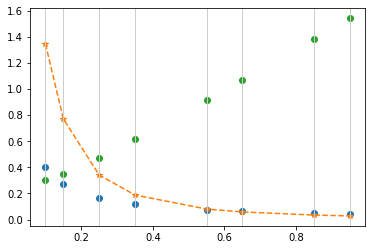

In [ ]:
plt.plot(frequencies_r['so'],amplitudes_r['so'],'o')
plt.plot(frequencies_r['so'],abs(M_h),'*--')
plt.plot(frequencies_r['so'],amplitudes_d['so'],'o')

base_freq = 0.05
prime = np.asarray([2, 3, 5, 7, 
                    11, 13, 17, 19])
for ii in prime:
  plt.axvline(x = ii*base_freq,linewidth=1, color='0.8') 

In [ ]:
num_refs = 15 # will generate double the number of refs
phase_shifts_r  = dict([(vf,np.random.sample((num_refs,p_max[vf]))) for vf in vfs]) 

# only first disturbance signal differs from reference signals
#print phase_shifts_r
phase_shifts_d = deepcopy(phase_shifts_r)
shiftedPhase = {}
for vf in vfs:
    phase_shifts_d[vf][:] = phase_shifts_d[vf][:]*.8
#phase_shifts_d = dict([(vf,shiftedPhase[vf]) for vf in vfs])
# for vf in vfs:
#   phase_shifts_d[vf][0] = np.random.rand(p_max[vf])
#
ramp = 0.25*period
duration = 2*period + ramp
#
trial = dict(ramp=ramp,duration=duration)
# DEBUG

In [ ]:
scale = dict(fo=0.,so=0.)
for vf in vfs:
  for _,phase_shift in enumerate(phase_shifts_r[vf]):
    t = np.arange(ramp,ramp+period,STEP)
    dt = np.diff(t)
    r = sos(t,trial,None,frequencies_r[vf],amplitudes_r[vf],phase_shift,None) #derivative = None
    dr = sos(t,trial,None,frequencies_r[vf],amplitudes_r[vf],phase_shift,1) #derivative = 1
    ddr = sos(t,trial,None,frequencies_r[vf],amplitudes_r[vf],phase_shift,2) #derivative = 2
    #
    if vf == 'fo':
      scale['fo'] = max(scale['fo'],np.abs(dr).max())
    elif vf == 'so':
      scale['so'] = max(scale['so'],np.abs(ddr).max())

In [ ]:
# # randomize to provide random starting point
# order = np.random.choice([0,1])
# if order == 0:
#     trialEO = [(1,'sos-E','sos+O'),(1,'sos-O','sos+E')]
# elif order == 1:
#     trialEO = [(1,'sos-O','sos+E'),(1,'sos-E','sos+O')]
# order

In [ ]:
ORDER = []
for i in range(15):
  ORDER.append((i,'sos-O', 'sos+E'))
  ORDER.append((i,'sos-E', 'sos+O'))
ORDER

[(0, 'sos-O', 'sos+E'),
 (0, 'sos-E', 'sos+O'),
 (1, 'sos-O', 'sos+E'),
 (1, 'sos-E', 'sos+O'),
 (2, 'sos-O', 'sos+E'),
 (2, 'sos-E', 'sos+O'),
 (3, 'sos-O', 'sos+E'),
 (3, 'sos-E', 'sos+O'),
 (4, 'sos-O', 'sos+E'),
 (4, 'sos-E', 'sos+O'),
 (5, 'sos-O', 'sos+E'),
 (5, 'sos-E', 'sos+O'),
 (6, 'sos-O', 'sos+E'),
 (6, 'sos-E', 'sos+O'),
 (7, 'sos-O', 'sos+E'),
 (7, 'sos-E', 'sos+O'),
 (8, 'sos-O', 'sos+E'),
 (8, 'sos-E', 'sos+O'),
 (9, 'sos-O', 'sos+E'),
 (9, 'sos-E', 'sos+O'),
 (10, 'sos-O', 'sos+E'),
 (10, 'sos-E', 'sos+O'),
 (11, 'sos-O', 'sos+E'),
 (11, 'sos-E', 'sos+O'),
 (12, 'sos-O', 'sos+E'),
 (12, 'sos-E', 'sos+O'),
 (13, 'sos-O', 'sos+E'),
 (13, 'sos-E', 'sos+O'),
 (14, 'sos-O', 'sos+E'),
 (14, 'sos-E', 'sos+O')]

In [ ]:
def trial_gen(subject,protofile):
  for vf in vfs:
    for assay,(num_reps,ref_,dis_) in enumerate(ORDER):
        shift_id  = num_reps
        
        if ref_[-1] == 'E':
          sines_r = np.arange(p_max[vf])[0::2]
        elif ref_[-1] == 'O':
          sines_r = np.arange(p_max[vf])[1::2]
        else:
          sines_r = np.arange(p_max[vf])
        if dis_[-1] == 'E':
          sines_d = np.arange(p_max[vf])[0::2]
        elif dis_[-1] == 'O':
          sines_d = np.arange(p_max[vf])[1::2]
        else:
          sines_d = np.arange(p_max[vf])

        # print(shift_id)
        # print(sines_r)
        # print(sines_d)
        # print(phase_shifts_r[vf][shift_id][sines_r])
        out = lambda x : x[0]

        ref = lambda t,trial,x=None : refs[ref_[:3]](t,trial,x,
                                                    frequencies_r[vf][sines_r],
                                                    amplitudes_r[vf][sines_r],
                                                    phase_shifts_r[vf][shift_id][sines_r])
        dis = lambda t,trial,x=None : refs[dis_[:3]](t,trial,x,
                                                    frequencies_d[vf][sines_d],
                                                    amplitudes_d[vf][sines_d],
                                                    phase_shifts_d[vf][shift_id][sines_d])
          #
        id = '%s_%s_r-%s_d-%s_s%d_p%da%d' % (subject,vf,ref_,dis_,seed,shift_id,assay)
        state = states[vf]
              #
        trial.update(dict(id=id,init=state,vf=vf,ref=ref,dis=dis,out=out,scale=scale[vf],
                                r=phase_shifts_r[vf][shift_id][sines_r][0],d=phase_shifts_d[vf][shift_id][sines_d][0]))
        yield trial

In [ ]:
gen = trial_gen('subject','protocol')

In [ ]:
TRIAL = {}
REF = {}
DIS = {}
for i in range(30):
  TRIAL['trial'+str(i)] = {}
for i in range(30):
  TRIAL['trial'+str(i)] = deepcopy(gen.__next__())
  REFfunc = deepcopy(TRIAL['trial'+str(i)]['ref'])
  DISfunc = deepcopy(TRIAL['trial'+str(i)]['dis'])
  REF['trial'+str(i)] = REFfunc(np.asarray(t),TRIAL['trial'+str(i)])
  DIS['trial'+str(i)] = DISfunc(np.asarray(t),TRIAL['trial'+str(i)])

In [ ]:
def FFT(data,N):
  return fft.fft(data)/N
def IFFT(data,N):
  return (fft.ifft(data)*N).real

N = len(t)                            # length of time
fs = 60                               #pygame update rate 60 Hz
xf_all = fft.fftfreq(N, 1./ fs)       #freq (x-axis) both + and - terms
xf = fft.fftfreq(N, 1./ fs)[:N//2]    #freq (x-axis) positive-frequency terms
M_h = M(1.j*2*np.pi*xf_all)           #M_hat = 1/ ((jw)^2 + (jw))

r = {}; d = {}; 
R = {}; D = {};
MD = {}; md = {};
WR = {}; wr = {};

for i in range(30):
  r['trial'+str(i)] = REF['trial'+str(i)]
  d['trial'+str(i)] = DIS['trial'+str(i)]
  R['trial'+str(i)] = FFT(r['trial'+str(i)],N)
  D['trial'+str(i)] = FFT(d['trial'+str(i)],N)      # d_h in freq domain
  MD['trial'+str(i)] = M_h * D['trial'+str(i)]      # Md_h in freq domain
  MD['trial'+str(i)][0] = 0                         #nan
  md['trial'+str(i)] = IFFT(MD['trial'+str(i)],N)   # Md in time domain

  WR['trial'+str(i)] = R['trial'+str(i)] / M_h
  WR['trial'+str(i)][0] = 0 #nan
  wr['trial'+str(i)] = IFFT(WR['trial'+str(i)],N) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
#scaling factors OUTPUT
MAXr = max( [max(r['trial'+str(i)]) for i in range(30)])
MINr = min( [min(r['trial'+str(i)]) for i in range(30)])

scaleOutput = 2*0.66/(MAXr-MINr) #in output time domain
scaleOutput

1.0000000000000002

In [ ]:
#check scaling factors OUTPUT of md in time domain
MAXmd = max( [max(md['trial'+str(i)]) for i in range(30)])
MINmd = min( [min(md['trial'+str(i)]) for i in range(30)])
scaleOutput_md = 2*0.66/(MAXmd-MINmd) #in output time domain
scaleOutput_md

0.9901503960265478

In [ ]:
#scaling factors INPUT
MAXwr = max( [max(wr['trial'+str(i)]) for i in range(30)])
MINwr = min( [min(wr['trial'+str(i)]) for i in range(30)])

scaleInput = 0.33/(MAXwr-MINwr) #in input time domain out of -0.5~+0.5
scaleInput

0.04616974606700115

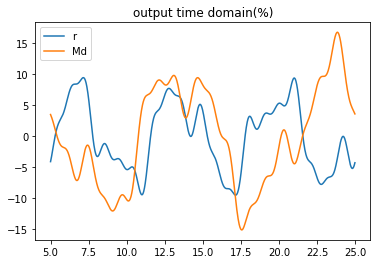

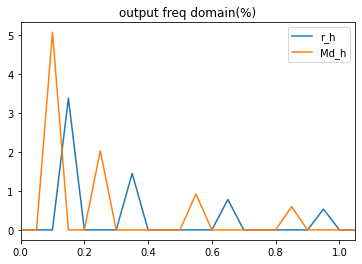

In [ ]:
#output space
scaleOutputScreen = 1/4
#plot ref and Mdis in time domain
plt.plot(t,r['trial0']*scaleOutputScreen*100,label = 'r')
plt.plot(t,md['trial0']*scaleOutputScreen*100,label = 'Md')
# plt.plot(t,d['trial0'],label = 'Md')

plt.legend()
plt.title('output time domain(%)')
plt.show()

plt.plot(xf,abs(R['trial0'][:N//2])*scaleOutputScreen*100,label = 'r_h')
plt.plot(xf,abs(MD['trial0'][:N//2])*scaleOutputScreen*100,label = 'Md_h')
plt.legend()
plt.title('output freq domain(%)')
plt.xlim((0,21*base_freq))
plt.show()

In [ ]:
np.sum(abs(MD['trial0'][:N//2])*scaleOutputScreen*100)

8.625454473355786

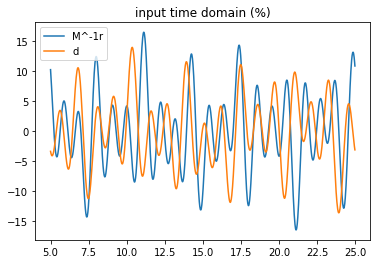

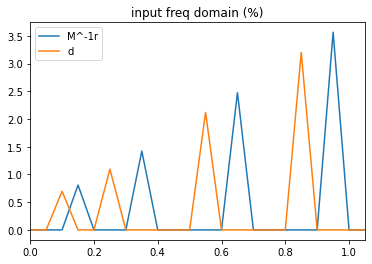

In [ ]:
#input space
#plot Wr and d in time domain
plt.plot(t,wr['trial0']*scaleInput*100,label = 'M^-1r')
plt.plot(t,d['trial0']*scaleInput*100,label = 'd')
plt.legend()
plt.title('input time domain (%)')
plt.show()

plt.plot(xf,abs(WR['trial0'][:N//2])*scaleInput*100,label = 'M^-1r')
plt.plot(xf,abs(D['trial0'][:N//2])*scaleInput*100,label = 'd')
plt.legend()
plt.title('input freq domain (%)')
plt.xlim((0,21*base_freq))
plt.show()

In [ ]:
max(abs(WR['trial0'][:N//2])*scaleInput*100)

3.5643569485271023

**TODO**

1. print r and Md and y (including Md & Mu) on screen *scaleOutput
2. remove trial['scale'] from input


In [ ]:
# transform from absolute pixel (col,row) to frame-relative (x,y)
def px2xy(px,size,SC):
  return [[(_[0]-size[0]/2.)/SC,(_[1]-size[1]/2.)/SC] for _ in px]
  #if ORIENTATION == 'portrait':
  #  return [[(_[0]-size[0]/2.)/SC,(_[1]-size[1]/2.)/SC] for _ in px]
  #else:
  #  return [[(_[1]-size[0]/2.)/SC,(_[0]-size[1]/2.)/SC] for _ in px]

# transform from frame-relative (x,y) to absolute pixel (col,row)
def xy2px(xy,size,SC):
  return [[int(SC*_[1]+size[0]/2.),int(size[1]/2.-SC*_[0])] for _ in xy]

size = (1000,250)
RATIO = 4
WIDTH = 200
size = (WIDTH,RATIO*WIDTH)
SC = float(WIDTH) # modify SC to change lookahead
SCi= WIDTH

In [ ]:
1/0.1846789842680046

5.414801277815175

In [ ]:
trial['scale']

5.162992526700608